# Building the network
In this notebook the network is constructed and filtered. The following things are done:

1. Construction of network from Spotify data.
2. Add genre as attribute to the network.
3. Remove nodes with degree `degree = 0`.
4. Remove nodes which has too few *top 5 song* lyrics downloaded.
5. Remove nodes which have songs that are not in english.

The end results is the final network which is used for analysis throughout the project.

In [ ]:
# Imports
import os
import json
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np
import scipy.stats as stats
import regex as re
from langdetect import detect

In [ ]:
sns.set()

We start by generating an un-directed graph since we are interested in observing if there are a collaborations between artists, rather than evaluating if one artists is featured in another artist song or vice-versa.

In [ ]:
G1 = nx.Graph()

Below the information about all the artists in the network is loaded.

In [ ]:
with open("../../data/network.json") as f:
        artists = json.load(f)

To build the network we can access the `artist` dictionary and extract the `edges` information.
For some of the nodes in the dictionary the information from Spotify has not been retrieved.
The attribute `isNode` is therefor added to specify is we will use this artist as a node or not. 

In [ ]:
for artist in artists:
    if artist['isNode']: # check if the artist is a node, in other words if we have information about the artist
        name = artist['name'] # get artist name
        id_ = artist['id'] # get artist id
        popularity = artist['popularity'] # get popularity of artist
        G1.add_nodes_from([(id_,{'name':name,'popularity':popularity})]) # add the artist as a node

        ## get edges of the artist
        edges = artist['edges']
        for edge in edges:
            if edge != id_: # if the edge is to a different node than the artist itself
                G1.add_edge(id_,edge) # add edge

In [ ]:
print("Number of nodes:",len(G1.nodes))
print("Number of edges:",len(G1.edges))

Number of nodes: 5653
Number of edges: 24084


Bellow the graph is saved, and will be used as our initialization graph.

In [ ]:
# Saving the Graph
nx.write_graphml(G1,"../../data/graphs/G_uNW.graphml",encoding='utf-8')

### Adding genre as attribute

From Spotify information about the genre of the artist is also available.
However, most artists will have several different genres, sometimes more than 10, which for data analysis makes it diffcult to work with.
To deal with this problem a network of genres is build in the Explainer Notebook. 
In the network, each nodes represents a genre and the edges represent if an artist has both of these genres in his genre list. 
This means that if for example the artist *Childish Gambino* has the genres *Rap* and *Hip-hop* an edge is created between these two genres.
As the same connection will occur often the weight of an edge increases as the connection appears more often. 
The same is done for the nodes, as a genre appears more often the weight of the node will also increase. 
With the network it is possible to divide it into partitions.
By evaluating the wordclouds of each partition it is possible to detect the overall genre for the partition and thereby also which genre/partition an artist belongs to.
The network loaded below, `G_ARTGen.gramphml`, is therefore the same network as before but with an genre attribute for each artist. 

The genres given to each artists might not be 100% correct for every artist, therefore
 results and conclusion of the analysis should be evaluated with this in mind.

In [ ]:
def show_diff_2networks(G1, G2):
    print("Number of nodes in new network:",len(G2.nodes))
    print("Number of edges in new network:",len(G2.edges))
    print("Number of nodes lost:", len(G1.nodes())-len(G2.nodes()))
    print("Number of edges lost:", len(G1.edges())-len(G2.edges()))

In [ ]:
# Load graph with genre as attribute
G2 = nx.read_graphml("../../data/graphs/G_ARTGen.graphml")
show_diff_2networks(G1,G2)

Number of nodes in new network: 5392
Number of edges in new network: 23550
Number of nodes lost: 261
Number of edges lost: 534


### Remove nodes with `degree = 0`

As we want to analyse the network of collaborations between artist there is no meaningful way to include nodes which has `degree = 0`, as these nodes have no other artists within the network that they have collaborated with.


In [ ]:
lonely_nodes = [elem[0] for elem in G2.degree() if elem[1]==0] # Find nodes with degree 0
G3 = G2.copy() # copy network
G3.remove_nodes_from(lonely_nodes) # remove the lonely nodes

In total 1398 nodes are thus removed from the network. 
To see how these differientate from the rest of the network we will look at the distribution of the genres and the popularity.

In [ ]:
# Get popularity of lonely nodes
pop_lonely = []
for node in lonely_nodes:
    pop_lonely.append(G2._node[node]['popularity'])

# Get popularity of all other nodes
pop_G3 = nx.get_node_attributes(G3,'popularity').values()
pop_G3 = np.array(list(pop_G3)) # convert dict_values to np.array

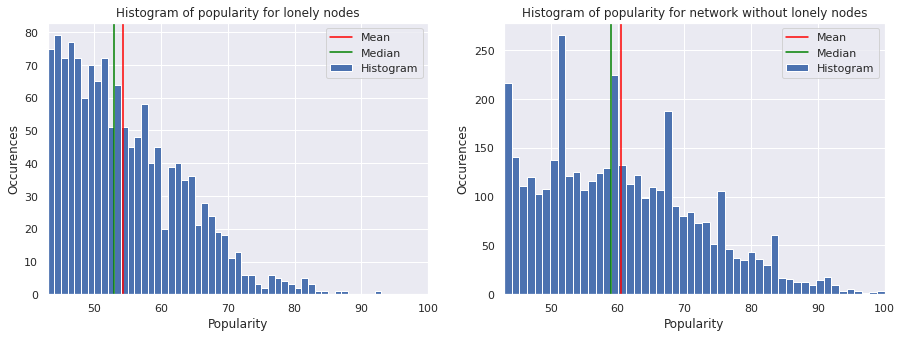

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Set limits for the x-axis
x_min_lim = min([min(pop_lonely), min(pop_G3)])
x_max_lim = max([max(pop_lonely), max(pop_G3)])

# Plot histogram for lonely nodes
ax1.hist(pop_lonely, bins = 50, label='Histogram')
ax1.set_title("Histogram of popularity for lonely nodes")
ax1.axvline(x=np.mean(pop_lonely), c= 'red', label='Mean')
ax1.axvline(x=np.median(pop_lonely), c= 'green', label='Median')
ax1.set_xlim([x_min_lim,x_max_lim])
ax1.set_xlabel('Popularity')
ax1.set_ylabel('Occurences')
ax1.legend()
# Plot histogram for network without lonely nodes
ax2.hist(pop_G3, bins = 50, label='Histogram')
ax2.set_title("Histogram of popularity for network without lonely nodes")
ax2.axvline(x=np.mean(pop_G3), c= 'red',label='Mean')
ax2.axvline(x=np.median(pop_G3), c= 'green', label='Median')
ax2.set_xlim([x_min_lim,x_max_lim])
ax2.set_xlabel('Popularity')
ax2.set_ylabel('Occurences')
ax2.legend()
plt.show()

The plot shows that both the mean, median and the general distribution of the popularity is skewed towards a much lower popularity for the lonely nodes compared to the nodes in the network without the lonely nodes.
The lonely nodes thus generally less populare based on the Spotify popularity measure.

Below the distribution of the proportion of artists which do not collaborate are shown for each genre.

In [ ]:
def dist_genres(G2, G3, nodes_list, title1, title2):
    # get genre of nodes_list
    genres = []
    for node in nodes_list:
        genres.append(G2._node[node]['genre'])

    # get genre of all other nodes
    genre_G3 = nx.get_node_attributes(G3,'genre').values()
    genre_G3 = np.array(list(genre_G3)) # convert dict_values to np.array

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

    ## Bar plot for lonely nodes
    counts_nodes_list = np.unique(genres,return_counts=True)
    ax1.bar(counts_nodes_list[0],counts_nodes_list[1])
    ax1.set_title(title1)
    ax1.set_xlabel('Genres')
    ax1.set_ylabel('Occurences')
    ax1.set_xticklabels(counts_nodes_list[0], rotation=45)


    ## Bar plot for network without lonely nodes
    counts_G3 = np.unique(genre_G3,return_counts=True)
    ax2.bar(counts_G3[0],counts_G3[1])
    ax2.set_title(title2)
    ax2.set_xlabel('Genres')
    ax2.set_ylabel('Occurences')
    ax2.set_xticklabels(counts_G3[0], rotation=45)

    plt.show()

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


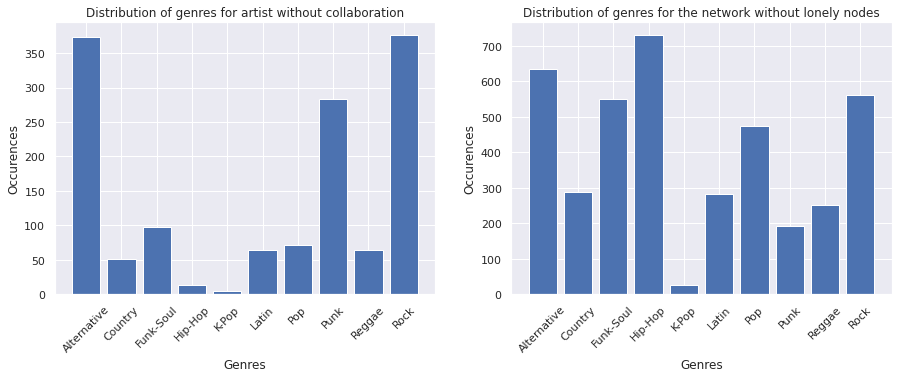

In [ ]:
dist_genres(G2,G3,lonely_nodes,
"Distribution of genres for artist without collaboration",
"Distribution of genres for the network without lonely nodes")

The plot shows that the lonely nodes are distributed very differently among the genres than the nodes in the network without the lonely nodes. 
Most of the lonely nodes are from the three genres *Alternative*, *Punk* and *Rock*. 
To get a better idea of the proportion of lonely nodes, and thereby the artists which do not collaborate, the percentage of lonely nodes out of all the nodes is illustrated below.

In [ ]:
def percentage_plot(G1, G2, nodes_list, title_):
    # get genre of nodes_list
    genres = []
    for node in nodes_list:
        genres.append(G1._node[node]['genre'])

    # get genre of all other nodes
    genre_G2 = nx.get_node_attributes(G2,'genre').values()
    genre_G2 = np.array(list(genre_G2)) # convert dict_values to np.array

    counts_nodes_list = np.unique(genres,return_counts=True)
    counts_G2 = np.unique(genre_G2,return_counts=True)


    plt.bar(counts_G2[0],100*counts_nodes_list[1]/(counts_nodes_list[1]+counts_G2[1]))
    plt.xlabel("Genre")
    plt.ylabel("Percentage")
    plt.title(title_)
    plt.xticks(rotation=45)
    plt.show()

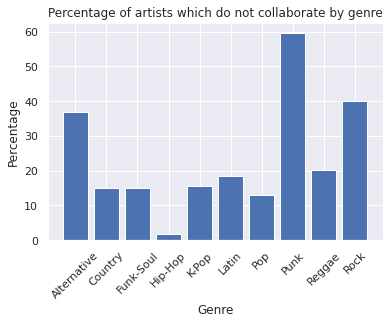

In [ ]:
percentage_plot(G2,G3, lonely_nodes, "Percentage of artists which do not collaborate by genre")

The plot shows that within the three genres, *Alternative*, *Punk* and *Rock*, a large porpotion of the artists do not collaborate.
It can further be seen that within the genre *Hip-Hop* only a small percentage of the artists do not collaborate.
The plot thus shows that in our subset of artist whether or not an artist collaborates with other artist depends on the genre of the artist.

### Remove nodes which has too few *top 5 song* lyrics downloaded.

As a part of the scraping of data the top 5 song lyrics (accordingly to the Spotify ratings in USA) were acquired from [genius](https://genius.com/) for each artist.
However, during analysis it was found that for several nodes we had not been succesfull in acquiring all 5 song lyrics.
This could be due to that the lyrics were not present on genius or that the song was instrumental and therefor no lyrics exists for the song.
Therefore a threshold for the amount of songs is needed which minimizes the amount of nodes lost while maximizing the amount of song lyrics.

Therefor to begin with every song lyrics which is not an empty text or instrumental is saved as a seperate `.txt` file.
At the same time the lyrics are cleaned for brackets and html text formatting symbols. 
 

In [ ]:
## Save all song lyrics which are not empty or instrumental
for artist_id in G3.nodes():
    with open("../../data/genius/genius_original_lyrics/" + artist_id + ".json") as json_file:
        temp = json.load(json_file)
    for song in temp: # Loop over all song lyrics
        song_lyric = song['lyrics']
        if (song_lyric != "") and (song_lyric != None) and (song_lyric != "[Instrumental]"): # Only proceed if song is not empty or instrumental
            # Remove square brackets, remove \n and remove the unicode whitespaces
            song_lyric_cleaned = re.sub("\s+", " ", re.sub(r"\[[^][]*]", "", song_lyric.replace('\n', ' ')), flags=re.UNICODE)
            # Remove normal '( )' brackets:
            song_lyric_cleaned = song_lyric_cleaned.replace("(","")
            song_lyric_cleaned = song_lyric_cleaned.replace(")","")
            # Save song lyric
            if song_lyric_cleaned != "" and len(song_lyric_cleaned) > 30: # Sometimes the song lyric might only consist of [artist name] or a few letters, we remove these
                text_file = open("../../data/genius/all_song_lyrics_cleaned/" + song['id'] + ".txt","w")
                text_file.write(song_lyric_cleaned)
                text_file.close()

In [ ]:
song_ids = os.listdir("../../data/genius/all_song_lyrics_cleaned/") # get list of all songs
song_ids = [id_[:-4] for id_ in song_ids] # remove the '.txt' at the end
print("Number of songs, sucessfully downloaded:",len(song_ids))
print("Number of songs there should be:", len(G3.nodes())*5)

Number of songs, sucessfully downloaded: 16072
Number of songs there should be: 19970


The print shows that alot of songs have not been downloaded. 
Below the amount of song lyrics not downloaded as a function of the number of artist is visualized.

In [ ]:
nodes_missing = []
for i in range(1,6): # Loop over all possiblities of minimum amount of lyrics downloaded
    failed_nodes = [] # Contains the nodes which did not meet the 'i' requirement
    # Get the song lyrics
    for node_id in G3.nodes():
        with open("../../data/genius/genius_original_lyrics/" + node_id + ".json") as json_file:
            temp = json.load(json_file)
        song_lyric = 0 # count the amount of 
        for song in temp: # Loop over all song of the artist
            if song['id'] in song_ids: # We only count the song if we downloaded it, and there by ensured that there is a song lyric
                song_lyric += 1
                
        # If an artist does not have the minimum amount we call it a "failed" artist
        if song_lyric < i:
            failed_nodes.append(node_id)

    nodes_missing.append(len(failed_nodes))

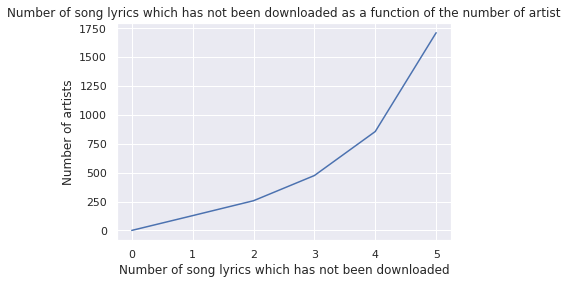

In [ ]:
# Plot the nodes missing
plt.plot(np.arange(0,6),[0]+nodes_missing)
plt.ylabel("Number of artists")
plt.xlabel("Number of song lyrics which has not been downloaded")
plt.title("Number of song lyrics which has not been downloaded as a function of the number of artist")
plt.show()

The graph shows that by setting the threshold at 2 song lyrics around a 125 artists will be lost.
As the threshold increases more and more artist fail to reach the requirement. 
And at the maximum of 5 lyrics more than 1700 artist will be lost. 
The optimal threshold thus seems to be at 3 lyrics. 
With this threshold only a smaller amount of artists are lost while maintaining a minimum of 3 lyrics for each artist and thus more data for text analysis.
The amount of songs will also be important for sentiment analysis as basing the sentiment of an artist on for example just one song would not be representative.
All artists with less than 3 lyrics are therefor removed.


In [ ]:
## Find the nodes which needs to be removed from the network
failed_nodes = [] # store the artist id of the nodes which needs to be removed
for node_id in G3.nodes():
    with open("../../data/genius/genius_original_lyrics/" + node_id + ".json") as json_file:
        temp = json.load(json_file)
    song_lyric = 0 # count songs
    for song in temp:
        if song['id'] in song_ids:
            song_lyric += 1
    if song_lyric < 3: # if we count less than 3 songs
        failed_nodes.append(node_id)

print("Number of nodes with less than three song lyrics:",len(failed_nodes))

Number of nodes with less than three song lyrics: 475


In [ ]:
G4 = G3.copy() # copy network
G4.remove_nodes_from(failed_nodes) # removed nodes
show_diff_2networks(G3,G4)

Number of nodes in new network: 3519
Number of edges in new network: 18999
Number of nodes lost: 475
Number of edges lost: 4551


Below the removed artists are looked into.

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


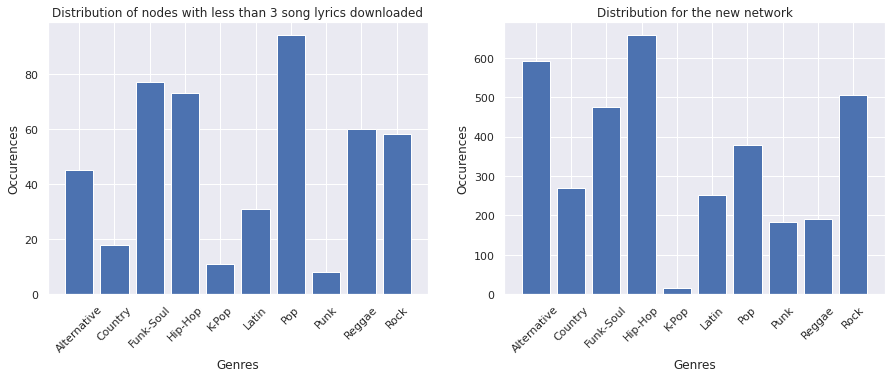

In [ ]:
dist_genres(G3,G4,failed_nodes, "Distribution of nodes with less than 3 song lyrics downloaded",
"Distribution for the new network")

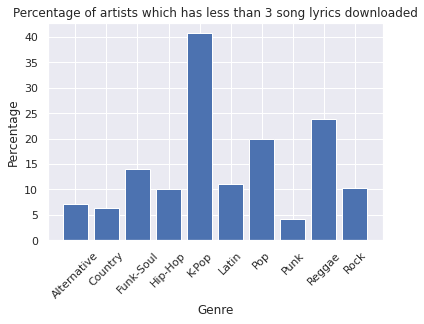

In [ ]:
percentage_plot(G3,G4,failed_nodes,"Percentage of artists which has less than 3 song lyrics downloaded")

The plot shows that while there are most artist from the genre *Pop* which are lost, the realtive percentage is bigger for *Reggae* and *K-Pop*.
This could also make sense as one would suspect that there are more artist within these two genres which are less famous.

### Remove nodes which have songs that are not in english.
During analysis it was further found that several artists had several song lyrics downloaded, but that these were in a foreign language.
It is possible to translate the lyrics of these songs by using the library `googletrans`, but to limit the size of the project these songs are ignored.
To detect the langauge of a song the function `langdetect.detect` is used, which returns the language code of a text.

The code block below creates a dictionary for the none english artist and the english artists.

In [ ]:
artist_song_id = {} # Dictionary for artist and their songs
non_english_artist = {} # List for non english artists and their songs

for artist_id in G4.nodes():
    with open("../../data/genius/genius_original_lyrics/" + artist_id + ".json") as json_file:
        temp = json.load(json_file)
    songs = [] # To store english songs
    songs_int = [] # To store non english songs
    for song in temp:
        if song['id'] in song_ids: # check if the song is among the downloaded ones
            # Check if the text is in english:
            text_file = open("../../data/genius/all_song_lyrics_cleaned/" + song['id'] + ".txt", "r").read()
            language = detect(text_file)
            if language == 'en':
                songs.append(song['id'])
            else:
                songs_int.append(song['id'])
    # Only append to dictionary if more than 3 songs are in english
    if len(songs) >= 3:
        artist_song_id[artist_id] = songs
    else:
        non_english_artist[artist_id] = songs_int

In [ ]:
G5 = G4.copy() # copy network
G5.remove_nodes_from(non_english_artist.keys()) # remove the lonely nodes
show_diff_2networks(G4,G5)

Number of nodes in new network: 3190
Number of edges in new network: 17099
Number of nodes lost: 329
Number of edges lost: 1900


Below the removed artists are looked into.

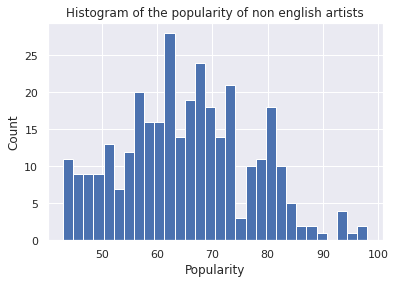

In [ ]:
# popularity
temp_popularity = []
for artist_id in non_english_artist.keys():
    temp_popularity.append(G4._node[artist_id]['popularity'])

plt.hist(temp_popularity,bins=30)
plt.title("Histogram of the popularity of non english artists")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

The plot shows that while there are some artists with higher poppularity, the majority of the artists are below 70.

In [ ]:
np.array(list(genres))

array(['Reggae', 'Punk', 'Rock', 'Alternative', 'Latin', 'Pop', 'Hip-Hop',
       'Funk-Soul', 'K-Pop'], dtype='<U11')

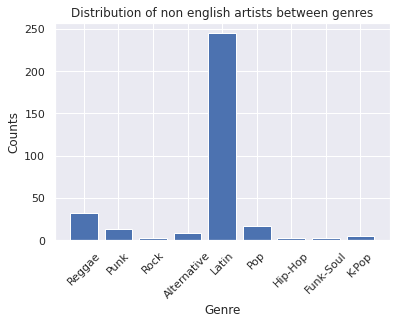

In [ ]:
# genre distribution
temp_genre = []
for artist_id in non_english_artist.keys():
    temp_genre.append(G4._node[artist_id]['genre'])
counts=[]
genres = set(temp_genre)
for genre in genres:
    counter = 0
    for i in temp_genre:
        if i == genre:
            counter+=1
    counts.append(counter)

plt.bar(list(genres),counts)
plt.xlabel("Genre")
plt.ylabel("Counts")
plt.title("Distribution of non english artists between genres")
plt.xticks(rotation=45)
plt.show()

The graphs thus shows that most of the latin artists are removed.
We therefore further needs to check how many artists from each genre are left in the network.

In [ ]:
non_english_id = np.array(list(non_english_artist.keys()))

genres = []
for node in non_english_id:
    genres.append(G4._node[node]['genre'])

# get genre of all other nodes
genre_G5 = nx.get_node_attributes(G5,'genre').values()
genre_G5 = np.array(list(genre_G5)) # convert dict_values to np.array

counts_nodes_list = np.unique(genres,return_counts=True)
counts_G5 = np.unique(genre_G5,return_counts=True)

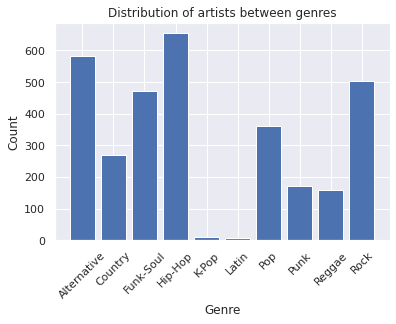

In [ ]:
plt.bar(counts_G5[0],counts_G5[1])
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Distribution of artists between genres")
plt.xticks(rotation=45)
plt.show()

The plot shows that we now have very few artists left in the genre *K-Pop* and *Latin*.
It thus does not make sense to have these genres in the dataset and the nodes within are therefor removed.

In [ ]:
remove_nodes = []

for artist_id in G5.nodes():
    node_genre = G5._node[artist_id]['genre']
    if node_genre == 'K-Pop' or node_genre == 'Latin':
        remove_nodes.append(artist_id)
print("Artists which will be removed:", len(remove_nodes))

Artists which will be removed: 18


In [ ]:
G6 = G5.copy() # copy network
G6.remove_nodes_from(remove_nodes) # remove the lonely nodes
show_diff_2networks(G5,G6)

Number of nodes in new network: 3174
Number of edges in new network: 17155
Number of nodes lost: 18
Number of edges lost: 59


Finally, as we have removed several artists from the network we should once again check if we have nodes with `degree = 0` and if we have remove them.

In [ ]:
lonely_nodes = [elem[0] for elem in G6.degree() if elem[1]==0] # Find nodes with degree 0
G7 = G6.copy() # copy network
G7.remove_nodes_from(lonely_nodes) # remove the lonely nodes
show_diff_2networks(G6,G7)

Number of nodes in new network: 3098
Number of edges in new network: 17155
Number of nodes lost: 76
Number of edges lost: 0


Finally the network is saved as `G_final.graphml`.

In [ ]:
## Final network is saved:
nx.write_graphml(G7,"../../data/graphs/G_final.graphml",encoding='utf-8')

Lastly an updated version, based on the G7 network, of the dictionary `artist_song_id` is constructed.
The dictionary contains the song lyric id for each artist id and is used for later analysis.

In [ ]:
## Update dictionary artist_song_id
artist_song_id_temp = {}
for artist_id in G7.nodes():
    artist_song_id_temp[artist_id] = artist_song_id[artist_id]

## Save the list of non english artists
with open("../../data/other_files/artist_song_id.json", "w") as json_file:
    json.dump(artist_song_id_temp,json_file)